<a href="https://colab.research.google.com/github/Affanamin/TimeSeries_projects/blob/master/TimeSeries_LSTM_HyperParaOptimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [284]:
!pip install scikit-optimize

In [0]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
#from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [0]:
#from google.colab import files
#src = list(files.upload().values())[0]
#open('download.py','wb').write(src)
import download

In [0]:
#from google.colab import files
#src = list(files.upload().values())[0]
#open('weather.py','wb').write(src)
import weather

In [288]:
weather.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [289]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

In [290]:

%%time
df = weather.load_resampled_data()

CPU times: user 19.6 ms, sys: 28.6 ms, total: 48.3 ms
Wall time: 51 ms


In [291]:
df.head()

Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 20 columns]

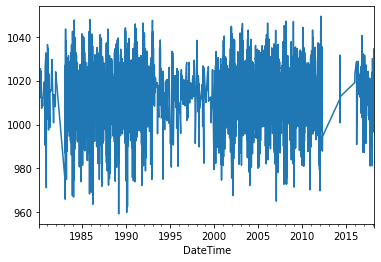

In [292]:
## EDA Starts Here
##Missing Data


df['Esbjerg']['Pressure'].plot();



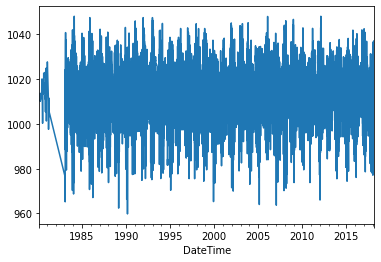

In [293]:
df['Roskilde']['Pressure'].plot();

In [294]:
df.values.shape

(333109, 20)

In [0]:
#Removing Columns
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

In [0]:
##ADD Data  -----------------------------------------------------------------------------------------------------

df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

In [297]:
df

Aalborg                         ...    Roskilde Various     
                         Temp     Pressure WindSpeed  ...     WindDir     Day Hour
DateTime                                              ...                         
1980-03-01 11:00:00  5.000000  1007.766667      10.2  ...  280.000000      61   11
1980-03-01 12:00:00  5.000000  1008.000000      10.3  ...  280.000000      61   12
1980-03-01 13:00:00  5.000000  1008.066667       9.7  ...  278.333333      61   13
1980-03-01 14:00:00  4.333333  1008.133333      11.1  ...  270.000000      61   14
1980-03-01 15:00:00  4.000000  1008.200000      11.3  ...  270.000000      61   15
...                       ...          ...       ...  ...         ...     ...  ...
2018-03-01 19:00:00 -4.400000  1024.200000       7.2  ...   60.000000      60   19
2018-03-01 20:00:00 -4.300000  1023.700000       6.7  ...   70.000000      60   20
2018-03-01 21:00:00 -3.900000  1023.100000       8.8  ...   60.000000      60   21
2018-03-01 22:00:00 -3.800000  1022.900000       7.2  ...   60.000000      60   22
2018-03-01 23:00:00 -4.200000  1022.500000       7.2  ...   60.000000      60   23

[333109 rows x 20 columns]

In [0]:
target_city = 'Odense'

In [0]:
target_names = ['Temp', 'Pressure']

In [0]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [0]:
df_targets = df[target_city][target_names].shift(-shift_steps)

In [302]:
df[target_city][target_names].head(shift_steps + 5)

,Temp,Pressure
DateTime,,
1980-03-01 11:00:00,6.142857,1011.066667
1980-03-01 12:00:00,7.000000,1011.200000
1980-03-01 13:00:00,7.000000,1011.300000
1980-03-01 14:00:00,6.857143,1011.400000
1980-03-01 15:00:00,6.000000,1011.500000
1980-03-01 16:00:00,4.909091,1011.688889
1980-03-01 17:00:00,3.953488,1011.877778
1980-03-01 18:00:00,3.674419,1012.066667
1980-03-01 19:00:00,3.395349,1012.255556


In [303]:

df_targets.tail()
df_targets.shape

(333109, 2)

In [304]:
#Coverting to numpy arrays

x_data = df.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

num_data = len(x_data)
num_data



<class 'numpy.ndarray'>
Shape: (333085, 20)
<class 'numpy.ndarray'>
Shape: (333085, 2)


333085

In [305]:

#Train test split
train_split = 0.9
num_train = int(train_split * num_data)
print(num_train)

#num_test = num_data - num_train
#print(num_test)

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print ("X_lenghts" , len(x_train) + len(x_test))

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
#len(y_train) + len(y_test)
print ("Y_lenghts" , len(y_train) + len(y_test))

num_x_signals = x_data.shape[1]
print(num_x_signals)

num_y_signals = y_data.shape[1]
print(num_y_signals)

299776
X_lenghts 333085
Y_lenghts 333085
20
2


In [0]:
##Data Scaling

x_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)



In [307]:


print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 2)


In [0]:
## Data Generator


def batch_generator(batch_size, sequence_length):
    """
    #Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [309]:

batch_size = 256
sequence_length = 24 * 7 * 8
sequence_length
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)
x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 2)


In [0]:
## We can plot one of the 20 input-signals as an example.

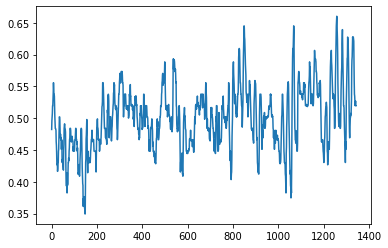

In [311]:

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [0]:
#seq = y_batch[batch, :, signal]
#plt.plot(seq)

In [0]:
## Validation Set

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')

In [0]:
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

In [0]:
#dim_num_dense_nodes = Integer(low=1, high=512, name='num_dense_nodes')
dim_num_dense_nodes = Integer(low=1, high=2, name='num_dense_nodes')

In [0]:
dim_activation = Categorical(categories=['relu', 'sigmoid'],
                             name='activation')

In [0]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

#default_parameters = [1e-5, 1, 16, 'relu']
default_parameters = [1e-5, 1, 2, 'relu']

In [0]:

def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

In [0]:
## Loss Function

warmup_steps = 50

def loss_mse_warmup(y_true, y_pred):
    """
    #Calculate the Mean Squared Error between y_true and y_pred,
    #but ignore the beginning "warmup" part of the sequences.
    
    #y_true is the desired output.
    #y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [0]:
from tensorflow.keras.layers import LSTM
def create_model(learning_rate, num_dense_layers,num_dense_nodes, activation):
   # Start construction of a Keras Sequential model.
    model = Sequential()
    print("Working 01")

    model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
    print("Working 02")
    
    #model.add(Dense(num_y_signals, activation='sigmoid'))
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))
    print("Working 03")

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    #model.add(Dense(num_classes, activation='softmax'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    print("Working 04")
    optimizer = RMSprop(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    print("Working 05")
    model.compile(optimizer=optimizer,
                  loss= loss_mse_warmup,
                  #loss = 'mean_squared_error',
                  metrics=['accuracy'])
    print("Working 06")
    return model
  


    

In [0]:
from tensorflow.keras import backend as K
best_accuracy = 0.0
path_best_model = '19_best_model.h5'


In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
 
    # Use Keras to train the model.
    history = model.fit(x=generator,
                        epochs=3,
                        steps_per_epoch=100,
                        #batch_size=128,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [0]:
#Test Run
#fitness(x=default_parameters)

In [325]:
%%time
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 2
activation: relu

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 51s 515ms/step - loss: 0.1256 - accuracy: 0.8764 - val_loss: 0.1061 - val_accuracy: 0.9005
Epoch 2/3
100/100 [==============================] - 51s 509ms/step - loss: 0.1016 - accuracy: 0.8780 - val_loss: 0.1051 - val_accuracy: 0.9005
Epoch 3/3
100/100 [==============================] - 51s 510ms/step - loss: 0.1013 - accuracy: 0.8782 - val_loss: 0.1050 - val_accuracy: 0.9005

Accuracy: 90.05%

learning rate: 7.8e-03
num_dense_layers: 2
num_dense_nodes: 2
activation: sigmoid

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 52s 519ms/step - loss: 0.0138 - accuracy: 0.8661 - val_loss: 0.0108 - val_accuracy: 0.9005
Epoch 2/3
100/100 [==============================] - 51s 513ms/step - loss: 0.0123 - accuracy: 0.8783 - val_lo

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 52s 516ms/step - loss: 0.2345 - accuracy: 0.8678 - val_loss: 0.2126 - val_accuracy: 0.9005
Epoch 2/3
100/100 [==============================] - 51s 511ms/step - loss: 0.1832 - accuracy: 0.8777 - val_loss: 0.1670 - val_accuracy: 0.9005
Epoch 3/3
100/100 [==============================] - 51s 510ms/step - loss: 0.1450 - accuracy: 0.8773 - val_loss: 0.1343 - val_accuracy: 0.9005

Accuracy: 90.05%

learning rate: 1.1e-06
num_dense_layers: 1
num_dense_nodes: 2
activation: relu

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 52s 516ms/step - loss: 0.2508 - accuracy: 0.1221 - val_loss: 0.2377 - val_accuracy: 0.0995
Epoch 2/3
100/100 [==============================] - 51s 509ms/step - loss: 0.2175 - accuracy: 0.1231 - val_loss: 0.2112 - val_accuracy: 0.0995
Epoch 3/3
100/100 [==============================] - 51s 509

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.0e-06
num_dense_layers: 1
num_dense_nodes: 2
activation: relu

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 52s 516ms/step - loss: 0.2419 - accuracy: 0.1229 - val_loss: 0.2306 - val_accuracy: 0.0995
Epoch 2/3
100/100 [==============================] - 51s 510ms/step - loss: 0.2118 - accuracy: 0.1226 - val_loss: 0.2036 - val_accuracy: 0.0995
Epoch 3/3
100/100 [==============================] - 51s 510ms/step - loss: 0.1643 - accuracy: 0.1217 - val_loss: 0.1341 - val_accuracy: 0.0995

Accuracy: 9.95%

learning rate: 1.0e-06
num_dense_layers: 1
num_dense_nodes: 2
activation: sigmoid

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 52s 516ms/step - loss: 0.0202 - accuracy: 0.4723 - val_loss: 0.0171 - val_accuracy: 0.8901
Epoch 2/3
100/100 [==============================] - 51s 509ms/step - loss: 0.0170 - accuracy: 0.8755 - val_los

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.0e-06
num_dense_layers: 1
num_dense_nodes: 2
activation: relu

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 51s 515ms/step - loss: 0.1853 - accuracy: 0.8640 - val_loss: 0.1618 - val_accuracy: 0.8951
Epoch 2/3
100/100 [==============================] - 51s 509ms/step - loss: 0.1293 - accuracy: 0.8715 - val_loss: 0.1084 - val_accuracy: 0.8987
Epoch 3/3
100/100 [==============================] - 51s 509ms/step - loss: 0.0826 - accuracy: 0.8744 - val_loss: 0.0654 - val_accuracy: 0.8996

Accuracy: 89.96%



/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.0e-06
num_dense_layers: 1
num_dense_nodes: 2
activation: relu

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 52s 518ms/step - loss: 0.2594 - accuracy: 0.7553 - val_loss: 0.2335 - val_accuracy: 0.9006
Epoch 2/3
100/100 [==============================] - 51s 510ms/step - loss: 0.2019 - accuracy: 0.8780 - val_loss: 0.1821 - val_accuracy: 0.9005
Epoch 3/3
100/100 [==============================] - 51s 509ms/step - loss: 0.1574 - accuracy: 0.8778 - val_loss: 0.1437 - val_accuracy: 0.9005

Accuracy: 90.05%

learning rate: 1.1e-06
num_dense_layers: 1
num_dense_nodes: 2
activation: relu

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 52s 516ms/step - loss: 0.2125 - accuracy: 0.6257 - val_loss: 0.1751 - val_accuracy: 0.6603
Epoch 2/3
100/100 [==============================] - 51s 510ms/step - loss: 0.1364 - accuracy: 0.7357 - val_loss:

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.0e-06
num_dense_layers: 1
num_dense_nodes: 2
activation: relu

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 52s 516ms/step - loss: 0.2037 - accuracy: 0.6982 - val_loss: 0.1736 - val_accuracy: 0.7466
Epoch 2/3
100/100 [==============================] - 51s 509ms/step - loss: 0.1351 - accuracy: 0.7840 - val_loss: 0.1100 - val_accuracy: 0.8335
Epoch 3/3
100/100 [==============================] - 51s 508ms/step - loss: 0.0812 - accuracy: 0.8386 - val_loss: 0.0614 - val_accuracy: 0.8784

Accuracy: 87.84%



/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.1e-06
num_dense_layers: 1
num_dense_nodes: 2
activation: relu

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 51s 515ms/step - loss: 0.2607 - accuracy: 0.7131 - val_loss: 0.2314 - val_accuracy: 0.9005
Epoch 2/3
100/100 [==============================] - 51s 509ms/step - loss: 0.1969 - accuracy: 0.8774 - val_loss: 0.1751 - val_accuracy: 0.9005
Epoch 3/3
100/100 [==============================] - 51s 509ms/step - loss: 0.1496 - accuracy: 0.8776 - val_loss: 0.1356 - val_accuracy: 0.9005

Accuracy: 90.05%



/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.0e-06
num_dense_layers: 1
num_dense_nodes: 2
activation: sigmoid

Working 01
Working 02
Working 03
Working 04
Working 05
Working 06
Epoch 1/3
100/100 [==============================] - 52s 516ms/step - loss: 0.0193 - accuracy: 0.7020 - val_loss: 0.0163 - val_accuracy: 0.8911
Epoch 2/3
100/100 [==============================] - 51s 509ms/step - loss: 0.0166 - accuracy: 0.8757 - val_loss: 0.0138 - val_accuracy: 0.9005
Epoch 3/3
100/100 [==============================] - 51s 509ms/step - loss: 0.0145 - accuracy: 0.8775 - val_loss: 0.0122 - val_accuracy: 0.9005

Accuracy: 90.05%

CPU times: user 1h 24min 7s, sys: 30min 6s, total: 1h 54min 13s
Wall time: 1h 45min 24s


In [328]:
#The best hyper-parameters found by the Bayesian optimizer are packed as a list because that is what it uses internally.
search_result.x

[1e-05, 1, 2, 'relu']

In [329]:
#All Combinations
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.9004773497581482, [1e-06, 1, 2, 'relu']),
 (-0.9004773497581482, [1.00055231268787e-06, 1, 2, 'relu']),
 (-0.9004773497581482, [1.0270975420478487e-06, 1, 2, 'relu']),
 (-0.9004773497581482, [1.031645954276585e-06, 1, 2, 'sigmoid']),
 (-0.9004773497581482, [1.0384491254884664e-06, 1, 2, 'sigmoid']),
 (-0.9004773497581482, [1.0705807450617685e-06, 1, 2, 'relu']),
 (-0.9004773497581482, [1.071357755235807e-06, 1, 2, 'relu']),
 (-0.9004773497581482, [1e-05, 1, 2, 'relu']),
 (-0.9004773497581482, [5.963501238949907e-05, 5, 2, 'sigmoid']),
 (-0.9004773497581482, [0.007847639489349701, 2, 2, 'sigmoid']),
 (-0.9004773497581482, [0.009187399323778867, 1, 2, 'sigmoid']),
 (-0.9004773497581482, [0.00957457917915935, 1, 2, 'sigmoid']),
 (-0.9004773497581482, [0.00972226822825089, 1, 2, 'sigmoid']),
 (-0.9004773497581482, [0.009827961666397543, 1, 2, 'sigmoid']),
 (-0.9004773497581482, [0.009953912326674029, 1, 2, 'sigmoid']),
 (-0.9003872871398926, [1.0115703414385757e-06, 1, 2, 'relu']),
 (

In [0]:
#Evaluate Best Model on Test-Set
#We can now use the best model on the test-set. It is very easy to reload the model using Keras.

In [0]:
from tensorflow.keras.models import load_model
#model = load_model(path_best_model)

In [0]:
#result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
 #                       y=np.expand_dims(y_test_scaled, axis=0))

In [0]:
#  Generate Predictions and plot.

LINK:

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

Exercises
These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

1. You may want to backup this Notebook before making any changes.

2. Remove the wind-speed from the target-data. Does it improve prediction for the temperature and pressure?

3. Train for more epochs, possibly with a lower learning-rate. Does it improve the performance on the test-set?

4. Try a different architecture for the neural network, e.g. higher or lower state-size for the GRU layer, more GRU layers, dense layers before and after the GRU layers, etc.


5. Use hyper-parameter optimization from Tutorial #19.

6. Try using longer and shorter sequences for the batch-generator.

7. Try and remove the city "Odense" from the input-signals.

8. Try and add last year's weather-data to the input-signals.

9. How good is the model at predicting the weather 3 or 7 days into the future?

10. Can you train a single model with the output-signals for multiple time-shifts, so that a single model predicts the weather in e.g. 1, 3 and 7 days.



Explain to a friend how the program works.

In [327]:
df_targets.tail(30)


,Temp,Pressure
DateTime,,
2018-02-28 18:00:00,-3.9,1020.8
2018-02-28 19:00:00,-4.4,1020.4
2018-02-28 20:00:00,-5.0,1019.8
2018-02-28 21:00:00,-5.2,1019.2
2018-02-28 22:00:00,-5.0,1018.7
2018-02-28 23:00:00,-4.7,1018.3
2018-03-01 00:00:00,NaN,NaN
2018-03-01 01:00:00,NaN,NaN
2018-03-01 02:00:00,NaN,NaN
